In [0]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
## Prepare Datasets
transform = transforms.Compose([
    transforms.ToTensor()
])
train_data = datasets.MNIST(root='data', train=True, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=512, shuffle=True, num_workers=5)

len(train_loader)

0it [00:00, ?it/s]

9920512it [00:02, 3909153.83it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 56430.22it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 863907.04it/s]                             
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 21466.50it/s]            

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


118

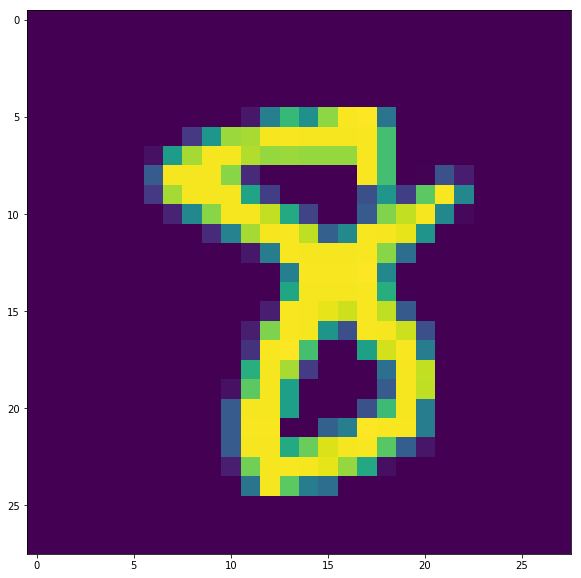

In [47]:
# visualize data
images, labels = next(iter(train_loader))

img = np.squeeze(images[0])

fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(111)
ax.imshow(img)

# Create Model

In [0]:
def xavier_init(m):
    """ Xavier initialization """
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

In [0]:
class DNet(nn.Module):

    def __init__(self):
        super(DNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

        self.model.apply(xavier_init)

    def forward(self, x):
        x = x.view(-1, 784)
        return self.model(x)


class GNet(nn.Module):

    def __init__(self):
        super(GNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 784),
            nn.Tanh()
        )

        self.model.apply(xavier_init)

    def forward(self, x):
        return self.model(x)

In [65]:
# Create models
model_ds = DNet()
model_gn = GNet()

# Move to cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ds.to(device)
model_gn.to(device)

GNet(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3)
    (3): Linear(in_features=128, out_features=784, bias=True)
    (4): Tanh()
  )
)

In [0]:
from torch import optim
criterion = nn.BCELoss().to(device)
optim_ds = optim.Adam(model_ds.parameters(), lr=0.001)
optim_gn = optim.Adam(model_gn.parameters(), lr=0.001)

In [81]:
for epoch in range(100):
    G_loss_run = 0.0
    D_loss_run = 0.0
    for i, data in enumerate(train_loader):
        X, _ = data
        batch_size = X.size(0)  # 4d 

        # Definig labels for real (1s) and fake (0s) images
        one_labels = torch.ones(batch_size, 1).to(device)  # True labels
        zero_labels = torch.zeros(batch_size, 1).to(device)  # Fake Labels

        # Random normal distribution for each image
        z = torch.randn(batch_size, 100)

        # Feed forward in discriminator both 
        # fake and real images
        D_real = model_ds(X.to(device))
        fakes = model_gn(z.to(device))
        D_fake = model_ds(fakes.to(device))

        # Defining the loss for Discriminator
        D_real_loss = F.binary_cross_entropy(D_real, one_labels)
        D_fake_loss = F.binary_cross_entropy(D_fake, zero_labels)
        D_loss = D_fake_loss + D_real_loss

        # backward propagation for discriminator
        optim_ds.zero_grad()
        D_loss.backward()
        optim_ds.step()

        ##############
        ### GN
        ################
        # Feed forward for generator
        z = torch.randn(batch_size, 100)
        fakes = model_gn(z.to(device))
        D_fake = model_ds(fakes.to(device))

        # loss function of generator
        G_loss = F.binary_cross_entropy(D_fake, one_labels)

        # backward propagation for generator
        optim_gn.zero_grad()
        G_loss.backward()
        optim_gn.step()

        G_loss_run += G_loss.item()
        D_loss_run += D_loss.item()

    # printing loss after each epoch 
    print('Epoch:{},   G loss:{},   D loss:{}'.format(epoch, G_loss_run / (i + 1), D_loss_run / (i + 1)))

Epoch:0,   G loss:1.4888717986769595,   D loss:1.2635729903891935
Epoch:1,   G loss:2.176134377212848,   D loss:1.325922694751772
Epoch:2,   G loss:1.6626308035042325,   D loss:1.1737568070322781
Epoch:3,   G loss:1.2781138314028917,   D loss:1.3242295445021937
Epoch:4,   G loss:1.3965273696487233,   D loss:1.2783327910859705
Epoch:5,   G loss:1.4504763009184498,   D loss:1.2502420499163158
Epoch:6,   G loss:1.3708439721899517,   D loss:1.2016940510879128
Epoch:7,   G loss:1.4325915979126753,   D loss:1.3398557133593803
Epoch:8,   G loss:1.3700676661426738,   D loss:1.2536491150573148
Epoch:9,   G loss:1.4418749263731099,   D loss:1.3552163293806172
Epoch:10,   G loss:1.595296860751459,   D loss:1.282886060617738
Epoch:11,   G loss:1.3246596586906303,   D loss:1.2624388771542048
Epoch:12,   G loss:1.2893586603261658,   D loss:1.3299964838108773
Epoch:13,   G loss:1.2801892636185985,   D loss:1.3078574411949868
Epoch:14,   G loss:1.2802954149448265,   D loss:1.3089796425932545
Epoch:15,

# Train 2

In [0]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size)  # real labels = 1

    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss


def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)  # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [57]:
import pickle as pkl

# training hyperparams
num_epochs = 100
last_output = 100

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

sample_size = 16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, last_output))
fixed_z = torch.from_numpy(fixed_z).float()


# train the network
model_ds.train()
model_gn.train()

for epoch in range(num_epochs):

    for batch_i, (real_images, _) in enumerate(train_loader):

        batch_size = real_images.size(0)
        real_images = real_images * 2 - 1

        # remove gradients
        optim_ds.zero_grad()

        # train with real image
        D_real = model_ds(real_images.to(device))
        d_real_loss = real_loss(D_real.cpu(), smooth=True)

        # generae fake image
        z = np.random.uniform(-1, 1, size=(batch_size, last_output))
        z = torch.from_numpy(z).float()
        fake_images = model_gn(z.to(device))

        D_fake = model_ds(fake_images.to(device))
        d_fake_loss = fake_loss(D_fake.cpu())

        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        optim_ds.step()

        ## Generator
        optim_gn.zero_grad()

        fake_images = model_gn(z.to(device))

        D_fake = model_ds(fake_images.to(device))
        g_loss = real_loss(D_fake.cpu())  # use real loss to flip labels

        g_loss.backward()
        optim_gn.step()

        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                epoch + 1, num_epochs, d_loss.item(), g_loss.item()))

    losses.append((d_loss.item(), g_loss.item()))

    model_gn.eval()  # eval mode for generating samples
    samples_z = model_gn(fixed_z.to(device))
    samples.append(samples_z)
    model_gn.train()  # back to train mode

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  100] | d_loss: 0.3252 | g_loss: 20.8105
Epoch [    2/  100] | d_loss: 0.3252 | g_loss: 21.1359
Epoch [    3/  100] | d_loss: 0.3252 | g_loss: 20.3975
Epoch [    4/  100] | d_loss: 0.3252 | g_loss: 20.7555
Epoch [    5/  100] | d_loss: 0.3252 | g_loss: 21.7650
Epoch [    6/  100] | d_loss: 0.3252 | g_loss: 21.4606
Epoch [    7/  100] | d_loss: 0.3252 | g_loss: 22.0812
Epoch [    8/  100] | d_loss: 0.3251 | g_loss: 21.0941
Epoch [    9/  100] | d_loss: 0.3251 | g_loss: 21.5352
Epoch [   10/  100] | d_loss: 0.3251 | g_loss: 21.3831
Epoch [   11/  100] | d_loss: 0.3251 | g_loss: 20.9818
Epoch [   12/  100] | d_loss: 0.3251 | g_loss: 22.0973
Epoch [   13/  100] | d_loss: 0.3251 | g_loss: 21.1521
Epoch [   14/  100] | d_loss: 0.3251 | g_loss: 21.0368
Epoch [   15/  100] | d_loss: 0.3251 | g_loss: 21.3824
Epoch [   16/  100] | d_loss: 0.3251 | g_loss: 21.9698
Epoch [   17/  100] | d_loss: 0.3251 | g_loss: 21.0951
Epoch [   18/  100] | d_loss: 0.3251 | g_loss: 21.6035
Epoch [   

Loss

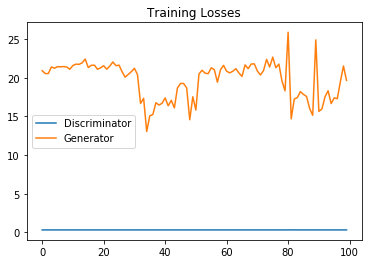

In [58]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

# Generate 1 Image

In [82]:
sample_size=1
rand_z = np.random.uniform(-1, 1, size=(sample_size, 100))
rand_z = torch.from_numpy(rand_z).float()
#z = torch.randn(batch_size, 100)

model_gn.eval() # eval mode
rand_images = model_gn(rand_z.to(device))

len(rand_images)

1

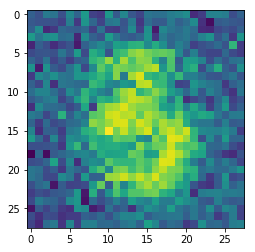

In [83]:
img = rand_images.cpu().detach()
plt.imshow(img.reshape((28,28)))

# Generate 16 images

In [0]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

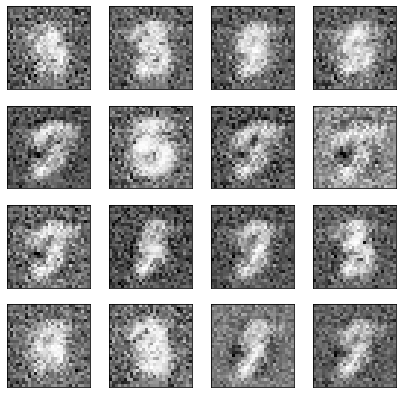

In [86]:
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, 100))
rand_z = torch.from_numpy(rand_z).float()

#z = torch.randn(64, 100)

model_gn.eval() # eval mode
rand_images = model_gn(rand_z.to(device))

len(rand_images)
view_samples(0, [rand_images.cpu()])